# Summary
In this notebook we just develop the code for loading a pre-trained model, a tokenizer and a validation set, and run a post modeling report on it.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.utils.data import DataLoader

os.chdir('/home/david/Desktop/projects/NameEmbedding/')
from src.dataset import CustomDataset

class PostModelingReportForExistingModel:
    def __init__(self, model, tokenizer, tokenizer_config, eval_dataset_path, experiment_location, device, n=np.inf):
        
        with open(eval_dataset_path, "r") as file:
            validation_names_txt = [line.strip() for line in file]
        validation_names_txt = validation_names_txt[:min(n,len(validation_names_txt))]
        eval_dataset = CustomDataset(
            text_list=validation_names_txt,
            tokenizer=tokenizer,
            max_len=tokenizer_config['max_len'], 
            include_attention_mask=True
            )

        self.model = model
        self.tokenizer = tokenizer
        self.tokenizer_config = tokenizer_config
        self.eval_dataset = eval_dataset
        self.experiment_location = experiment_location
        self.device = device
        self.plot_dir = os.path.join(experiment_location, 'plots')

    def _extract_embeddings(self, dataset):
        with torch.no_grad():
            embeddings = []
            for example in tqdm(dataset, desc="Extracting embeddings"):
                pred = self.model.base_model(example['input_ids'].unsqueeze(0).to(self.device)).last_hidden_state[0, 0, :].detach().cpu().numpy()
                embeddings.append(pred)
            return np.array(embeddings)

    def plot_embeddings_similarity(self):
        long_names = pd.read_csv('/home/david/Desktop/projects/NameEmbedding/data/testing/close_names_long.csv')
        long_names_shorter = long_names.iloc[:25, :]
        long_names_dataset = CustomDataset(
            text_list=long_names_shorter['name'].tolist(),
            tokenizer=self.tokenizer,
            max_len=self.tokenizer_config['max_len'],
            include_attention_mask=True
        )

        long_names_predictions = self._extract_embeddings(long_names_dataset)

        # UMAP and Clustering
        reducer = umap.UMAP(n_neighbors=50)
        embedding = reducer.fit_transform(self._extract_embeddings(self.eval_dataset))
        long_names_embeddings = reducer.transform(long_names_predictions)

        long_names_embeddings_pd = pd.DataFrame(long_names_embeddings)
        long_names_embeddings_pd['group'] = long_names['group']

        embedding_pd = pd.DataFrame(embedding)
        embedding_pd['group'] = 'all_the_rest'
        embedding_pd = pd.concat([embedding_pd, long_names_embeddings_pd], axis=0, ignore_index=True)

        # Clustering
        dbscan = DBSCAN(eps=1.0, min_samples=5)
        labels = dbscan.fit_predict(embedding_pd[[0, 1]])
        embedding_pd['cluster'] = labels

        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=embedding_pd, x=0, y=1, hue='group', alpha=0.5)
        plt.title("UMAP - Embeddings with Clustering")
        plt.savefig(f"{self.plot_dir}/clustering.png", format="png", dpi=300)

        # Individual Cluster Plots
        cluster_plots = self.create_cluster_plots(embedding_pd)
        for cluster_id, cluster_data in cluster_plots.items():
            plt.figure(figsize=(6, 6))
            sns.scatterplot(data=cluster_data, x=0, y=1, hue='group', alpha=0.8)
            plt.title(f"Cluster {cluster_id} - Size: {len(cluster_data)}", fontsize=14)
            plt.savefig(f"{self.plot_dir}/cluster_{cluster_id}.png", format="png", dpi=300)
            plt.close()

    def create_cluster_plots(self, embedding_pd, num_cluster_plots=4):
        # Perform clustering and get largest clusters
        dbscan = DBSCAN(eps=1.0, min_samples=5)
        labels = dbscan.fit_predict(embedding_pd[[0, 1]])
        embedding_pd['cluster'] = labels
        
        # Filter valid clusters (non-noise, i.e., label != -1) and sort by size
        cluster_sizes = embedding_pd[embedding_pd['cluster'] != -1]['cluster'].value_counts()
        largest_clusters = cluster_sizes.index[:num_cluster_plots]  # Get the largest clusters
        
        cluster_plots = {}
        for cluster_id in largest_clusters:
            cluster_plots[cluster_id] = embedding_pd[embedding_pd['cluster'] == cluster_id]
        
        return cluster_plots

    def k_fold_classification(self, dataset, labels):
        embeddings = self._extract_embeddings(dataset)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []

        labels = torch.tensor(labels)
        for train_index, val_index in kf.split(embeddings):
            train_embeddings, val_embeddings = embeddings[train_index], embeddings[val_index]
            train_labels, val_labels = labels[train_index], labels[val_index]

            # Train classifier
            classifier = LogisticRegression(max_iter=1000)
            classifier.fit(train_embeddings, train_labels)

            # Evaluate
            val_preds = classifier.predict(val_embeddings)
            accuracy = accuracy_score(val_labels, val_preds)
            accuracies.append(accuracy)

        avg_accuracy = np.mean(accuracies)
        return avg_accuracy
    
    def plot_embeddings_by_language(self):
        # Load the name vs. object dataset containing 'name' and 'language'
        df = pd.read_csv('./data/testing/names_and_languages_100k.csv')
        names = df['name'].tolist()
        languages = df['language'].tolist()

        # Create dataset from the names
        name_dataset = CustomDataset(
            text_list=names,
            tokenizer=self.tokenizer,
            max_len=self.tokenizer_config['max_len'],
            include_attention_mask=True
        )

        # Extract embeddings for the names
        name_embeddings = self._extract_embeddings(name_dataset)

        # Reduce embeddings to 2D using UMAP
        reducer = umap.UMAP(n_neighbors=50)
        reduced_embeddings = reducer.fit_transform(name_embeddings)

        # Create a DataFrame for the reduced embeddings
        embedding_df = pd.DataFrame(reduced_embeddings, columns=['UMAP1', 'UMAP2'])
        embedding_df['language'] = languages

        # Plot the UMAP with colors representing language
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', hue='language', alpha=0.8, palette='Set2')
        plt.title("UMAP - Name Embeddings Colored by Language")
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.legend(title="Language", loc='upper right')

        # Save the plot
        plt.savefig(f"{self.plot_dir}/umap_by_language.png", format="png", dpi=300)
        plt.close()


    def plot_group_cluster_distribution(self, group_cluster_analysis):
        # Prepare the data for plotting
        cluster_data = pd.DataFrame({
            'Group': list(group_cluster_analysis.keys()),
            'Number of Clusters': list(group_cluster_analysis.values())
        })

        # Sort the data by the number of clusters in increasing order
        cluster_data = cluster_data.sort_values(by='Number of Clusters', ascending=True)

        # Create the bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=cluster_data, x='Group', y='Number of Clusters', palette='viridis')

        plt.xlabel("Group", fontsize=14)
        plt.ylabel("Number of Clusters", fontsize=14)
        plt.title("Number of Clusters per Group of Names", fontsize=16)
        plt.xticks(rotation=90, ha='center')  # Rotate group names by 90 degrees for better readability
        plt.tight_layout()

        # Save the plot
        plt.savefig(f"{self.plot_dir}/group_cluster_distribution.png", format="png", dpi=300)
        plt.close()

    def generate_post_modeling_report(self):
        print('Starting Post modeling report')

        # Plot Embeddings Similarity
        self.plot_embeddings_similarity()

        # Load Word/Object dataset for classification
        df = pd.read_csv('./data/testing/name_vs_object.csv')
        words = df['Word'].values
        labels = df['Type'].apply(lambda x: 1 if x == 'name' else 0).values

        # Run K-Fold classification
        avg_accuracy = self.k_fold_classification(
            CustomDataset(
                text_list=words.tolist(),
                tokenizer=self.tokenizer,
                max_len=self.tokenizer_config['max_len'],
                include_attention_mask=True
            ),
            labels
        )
        print(f"Avg accuracy for word/object classifier: {avg_accuracy:.4f}")

        # Save KPIs
        KPI_table = {
            'KPI_name': ['Name_Object_ACC'],
            'KPI_value': [avg_accuracy]
        }

        # Calculate NMI and Average Clusters per Group
        long_names = pd.read_csv('/home/david/Desktop/projects/NameEmbedding/data/testing/close_names_long.csv')
        # Use the full dataset instead of slicing to include all names
        long_names_dataset = CustomDataset(
            text_list=long_names['name'].tolist(),
            tokenizer=self.tokenizer,
            max_len=self.tokenizer_config['max_len'],
            include_attention_mask=True
        )
        long_names_predictions = self._extract_embeddings(long_names_dataset)

        reducer = umap.UMAP(n_neighbors=50)
        long_names_embeddings = reducer.fit_transform(long_names_predictions)

        # DBSCAN for NMI and Average Clusters per Group
        long_names_embeddings_pd = pd.DataFrame(long_names_embeddings)
        long_names_embeddings_pd['group'] = long_names['group']

        dbscan = DBSCAN(eps=1.0, min_samples=5)
        labels = dbscan.fit_predict(long_names_embeddings_pd[[0, 1]])
        long_names_embeddings_pd['cluster'] = labels

        group_cluster_distribution = {}
        for group_name, group_data in long_names_embeddings_pd.groupby('group'):
            valid_clusters = group_data[group_data['cluster'] != -1]['cluster'].unique()
            group_cluster_distribution[group_name] = list(valid_clusters)

        # Analyze group-cluster distribution
        group_cluster_analysis = {
            group: len(clusters) for group, clusters in group_cluster_distribution.items()
        }

        # Plot group cluster distribution
        self.plot_group_cluster_distribution(group_cluster_analysis)

        # plot cluster-language distribution
        self.plot_embeddings_by_language()

        nmi_score = normalized_mutual_info_score(long_names_embeddings_pd['group'], long_names_embeddings_pd['cluster'])
        average_clusters_per_group = np.mean(list(group_cluster_analysis.values()))

        # Add to KPI table
        KPI_table['KPI_name'].extend(['NMI_close_names', 'average_clusters_per_group'])
        KPI_table['KPI_value'].extend([nmi_score, average_clusters_per_group])

        # Save KPIs to CSV
        pd.DataFrame(KPI_table).to_csv(f"{self.plot_dir}/KPIs.csv", index=False)

        print("Post modeling report generated successfully.")



/home/david/anaconda3/envs/demo_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from src.train import general_config, tokenizer_config, model_config, train_config
eval_dataset_path = "./data/raw/text/validation_names_processed.txt"
experiment_location = './experiments/experiment_1'
device = 'cuda'
tokenizer_path = experiment_location+"/tokenizer"
tokenizer = RobertaTokenizer(vocab_file = tokenizer_path + '/vocab.json', merges_file= tokenizer_path + '/merges.txt')

model_path = experiment_location+"/model"
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



/home/david/anaconda3/envs/demo_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./experiments/experiment_1/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(5000, 768, padding_idx=1)
      (position_embeddings): Embedding(32, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-1): 2 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [3]:
post_modeling_report_class = PostModelingReportForExistingModel(model, tokenizer, tokenizer_config, eval_dataset_path, experiment_location, device,n=100_000)


Preprocessing text into tokenized examples...


Tokenizing text: 100%|██████████| 100000/100000 [00:07<00:00, 14265.79it/s]


Starting Post modeling report
Preprocessing text into tokenized examples...


Extracting embeddings: 100%|██████████| 100000/100000 [02:06<00:00, 788.27it/s]


Preprocessing text into tokenized examples...


Extracting embeddings: 100%|██████████| 1600/1600 [00:02<00:00, 793.29it/s]


Avg accuracy for word/object classifier: 0.8156
Preprocessing text into tokenized examples...


Extracting embeddings: 100%|██████████| 1500/1500 [00:01<00:00, 785.96it/s]
/tmp/ipykernel_19034/2540276915.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_data, x='Group', y='Number of Clusters', palette='viridis')
/tmp/ipykernel_19034/2540276915.py:187: UserWarning: Glyph 3333 (\N{MALAYALAM LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_19034/2540276915.py:187: UserWarning: Matplotlib currently does not support Malayalam natively.
  plt.tight_layout()
/tmp/ipykernel_19034/2540276915.py:187: UserWarning: Glyph 3384 (\N{MALAYALAM LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_19034/2540276915.py:187: UserWarning: Glyph 3405 (\N{MALAYALAM SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_19034/2540276915.py:187: UserWa

KeyError: 'name'

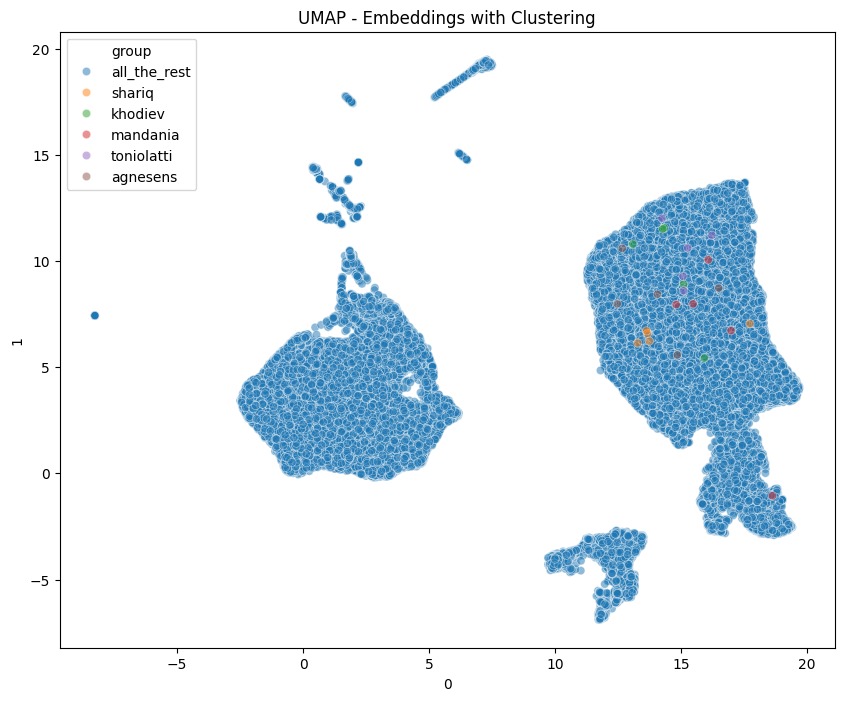

In [4]:
post_modeling_report_class.generate_post_modeling_report()

In [9]:
df = pd.read_csv('./data/testing/names_and_languages_100k.csv')
names = df['name'].tolist()
languages = df['language'].tolist()
df

,name,language
0,vibin lawrance,es
1,lemetyinemm,en
2,lathika thulaseedharan,en
3,riya cheriyan,sw
4,gollou,it
...,...,...
99995,jatautaitė,lt
99996,എബിൻ എൻ വി,ml
99997,മനാഫുദീൻ എസ്,ml
99998,devanandu,en
